In [1]:
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

############ Load linear regression data #############
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "strreg", "%s_strreg.tab"%t), sep="\t", usecols=["gene","str.start","p.wald"])
    data[t]["str.start"] = (data[t]["str.start"]).apply(int)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ExtractData(gene, chrom, start, tissue, newdata=True):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    if newdata:
        expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Review_Rerun/%s/Corr_Expr.csv"%tissue
    else: expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
def PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=None, newdata=True):
    ExtractData(gene, chrom, start, tissue, newdata=newdata)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
    fig = plt.figure()
    fig.set_size_inches((8,5))
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
        
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]
    print(set(data["str"]))
    boxcol = "gray"
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color="black", zorder=0)
    sns.boxplot(x="str", y="expr", ax=ax, data=data, color="white", linewidth=0.5, 
                boxprops={'facecolor':'None', 'edgecolor': boxcol}, showfliers=False)
    # Set box properties
    for i,artist in enumerate(ax.artists):
        artist.set_edgecolor(boxcol)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        x = 5
        for j in range(i*x,i*x+x):
            line = ax.lines[j]
            line.set_color(boxcol)
            line.set_mfc(boxcol)
            line.set_mec(boxcol)
    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    means["num"] = range(means.shape[0])
    
    ax.plot(means["num"], means["expr"], color="red", marker="o", linewidth=2)
    ax.set_xlabel("Mean num. rpts.", size=15)
    ax.set_ylabel("Normalized Expression - %s"%tissue, size=15)
    ax.set_xticklabels([(item*0.5+reflen)/period for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.1f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.suptitle("");
    plt.show()
    if fname is not None: fig.savefig(fname)

{-22, -20, -18, -16, -14, -12, -10, -8, -6}


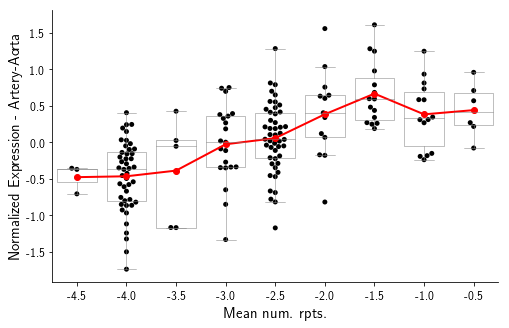

In [28]:
chrom = "chr3"
start = 53128363
end = 53128363
gene = "ENSG00000163933.5"
tissue = "Artery-Aorta"
period = 2
offset = 1
reflen = (end+1+offset-start)
reflen = (end+1+offset-start)
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=None, newdata=True)

{0, -24, -12}


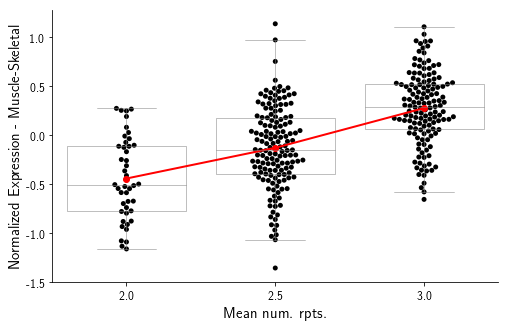

In [9]:
# CSTB
chrom = "chr21"
start = 45196326
end = 45196360
gene = "ENSG00000160213.5"
tissue = "Muscle-Skeletal"
period = 12
offset = 1
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "Figure1_Example_CSTB.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname)

{0, 36, 6, 42, 12, 48, 18, -12, 24, -6, 30}


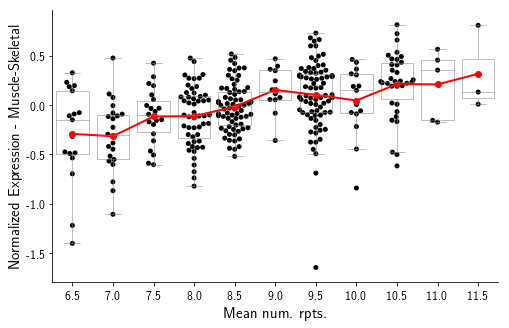

In [10]:
# NOP56
chrom="chr20"
start=2633379
end = 2633421
gene = "ENSG00000101361.10"
tissue = "Muscle-Skeletal"
period = 6
offset = 2
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "Figure1_Example_NOP56.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname)

{0, 6, -24, -18, -12, -6}


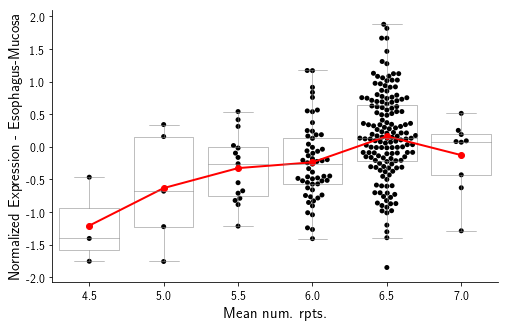

In [11]:
# ALOX5
gene = "ENSG00000012779.6"
chrom = "chr10"
start = 45869548
end = 45869585
tissue = "Esophagus-Mucosa"
period = 6
offset = 1
reflen = (end+1+offset-start)
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "Figure1_Example_ALOX5.pdf")
else: fname = None
PlotESTRPaper(gene, tissue, chrom, start, reflen, fname=fname)